## Loading and Preparation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna
from torch.utils.data import DataLoader
from torchinfo import summary

from utils.training import train, optuna_train, best_torch_device
from utils.dataset import EEGDataset
from models.Transformer import Transformer

/Users/muhanz/anaconda3/envs/147fn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

### Select Ideally GPU for Training

In [3]:
device = best_torch_device()
print(device)

mps


In [4]:
CP_PATH = "checkpoints/transformer/"

### Load Data

In [5]:
X_train = np.load('data/X_train_valid.npy')
y_train = np.load('data/y_train_valid.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

split_idx = 1777
X_train, X_valid = X_train[:split_idx], X_train[split_idx:]
y_train, y_valid = y_train[:split_idx], y_train[split_idx:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1777, 22, 1000)
y_train shape: (1777,)
X_valid shape: (338, 22, 1000)
y_valid shape: (338,)
X_test shape: (443, 22, 1000)
y_test shape: (443,)


In [50]:
train_set = EEGDataset(X_train, y_train, label_smoothing=True)
valid_set = EEGDataset(X_valid, y_valid, label_smoothing=True)
test_set = EEGDataset(X_test, y_test, label_smoothing=True)

In [51]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## Vision Transformer Model

In [56]:
from models.Transformer import ViTforEEG

raw_model = ViTforEEG().to(device)

summary(raw_model)

Layer (type:depth-idx)                                            Param #
ViTforEEG                                                         64,128
├─Linear: 1-1                                                     1,472
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          25,216
│    │    └─TransformerEncoderLayer: 3-2                          25,216
├─Sequential: 1-3                                                 --
│    └─Linear: 2-2                                                260
│    └─Softmax: 2-3                                               --
Total params: 116,292
Trainable params: 52,228
Non-trainable params: 64,064

In [52]:
optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.0001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_loader,
    val_data=valid_loader,
    early_stopping_patience=30,
    cp_path="models/transformer",
    cp_filename="raw.pt",
    n_epochs=100,
    show_progress_bar=False,
)

/Users/muhanz/Library/CloudStorage/OneDrive-UCLAITServices/UCLA/2024/Winter/EC ENGR C147/Project/ECE147-Final-Project/models/Transformer.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/muhanz/anaconda3/envs/147fn/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/muhanz/anaconda3/envs/147fn/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecat

Using device: mps
[Epoch 0] val_acc=0.263314 train_acc=0.257175 val_loss=0.045077 train_loss=0.043781
Validation loss decreased (inf --> 0.045077).  Saving model ...
[Epoch 1] val_acc=0.242604 train_acc=0.270681 val_loss=0.045127 train_loss=0.043697
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.263314 train_acc=0.245357 val_loss=0.045118 train_loss=0.043781
EarlyStopping counter: 2 out of 30
[Epoch 3] val_acc=0.242604 train_acc=0.245920 val_loss=0.045108 train_loss=0.043758
EarlyStopping counter: 3 out of 30
[Epoch 4] val_acc=0.263314 train_acc=0.229038 val_loss=0.045098 train_loss=0.043808
EarlyStopping counter: 4 out of 30
[Epoch 5] val_acc=0.263314 train_acc=0.234102 val_loss=0.045094 train_loss=0.043809
EarlyStopping counter: 5 out of 30
[Epoch 6] val_acc=0.242604 train_acc=0.241418 val_loss=0.045113 train_loss=0.043746
EarlyStopping counter: 6 out of 30
[Epoch 7] val_acc=0.242604 train_acc=0.238042 val_loss=0.045101 train_loss=0.043824
EarlyStopping counter: 7 out of 30
[

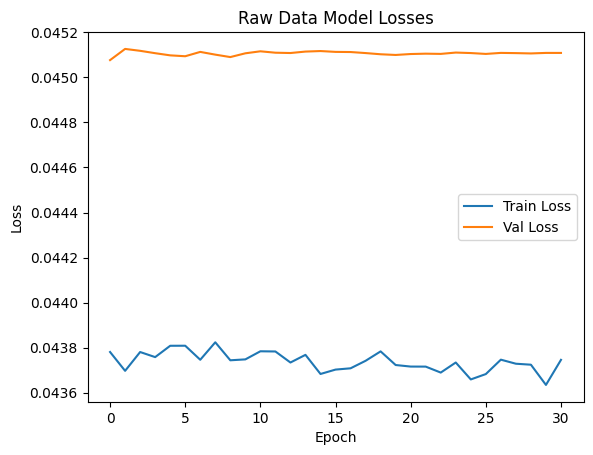

In [57]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

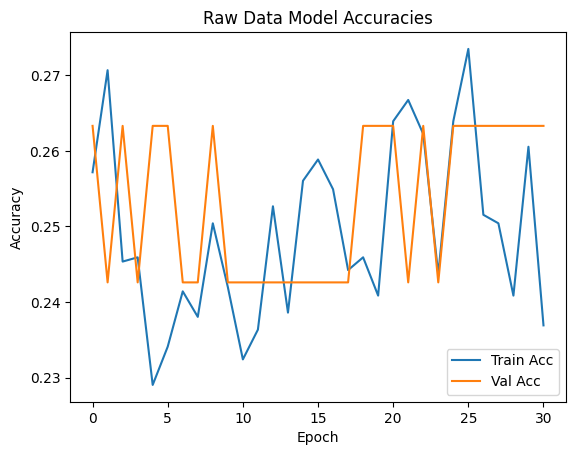

In [58]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [59]:
# Load best model and test
raw_model = torch.load("models/transformer/raw.pt")
raw_model.to(device)
raw_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=22, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [61]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.2167


## Model Experimentation

In [31]:
from models.Transformer import ViTforEEG 

new_model = ViTforEEG()

x = torch.randn(29, 22, 1000)
print(new_model(x).shape)

/Users/muhanz/Library/CloudStorage/OneDrive-UCLAITServices/UCLA/2024/Winter/EC ENGR C147/Project/ECE147-Final-Project/models/Transformer.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_emb = nn.Parameter(torch.tensor(positional_embedding(self.n_patches + 1, self.hidden_dims)))


torch.Size([29, 4])
